# Twitter Named Entity Recognition (NER) using LSTM+CRF and BERT

- Twitter is one of the most widely used social media platforms, where millions of users share information and opinions every day through short messages called tweets. These tweets often contain valuable insights about people, organizations, locations, events, and products. However, since many users do not use hashtags or use them incorrectly, it becomes challenging to identify trending topics or entities directly from raw text.

- This project focuses on developing a **Named Entity Recognition (NER)** system that can automatically detect and classify entities mentioned in tweets. By applying Natural Language Processing (NLP) and deep learning models such as **LSTM+CRF and BERT**, the project aims to extract meaningful information from unstructured tweet data to support trend analysis, topic detection, and content understanding.

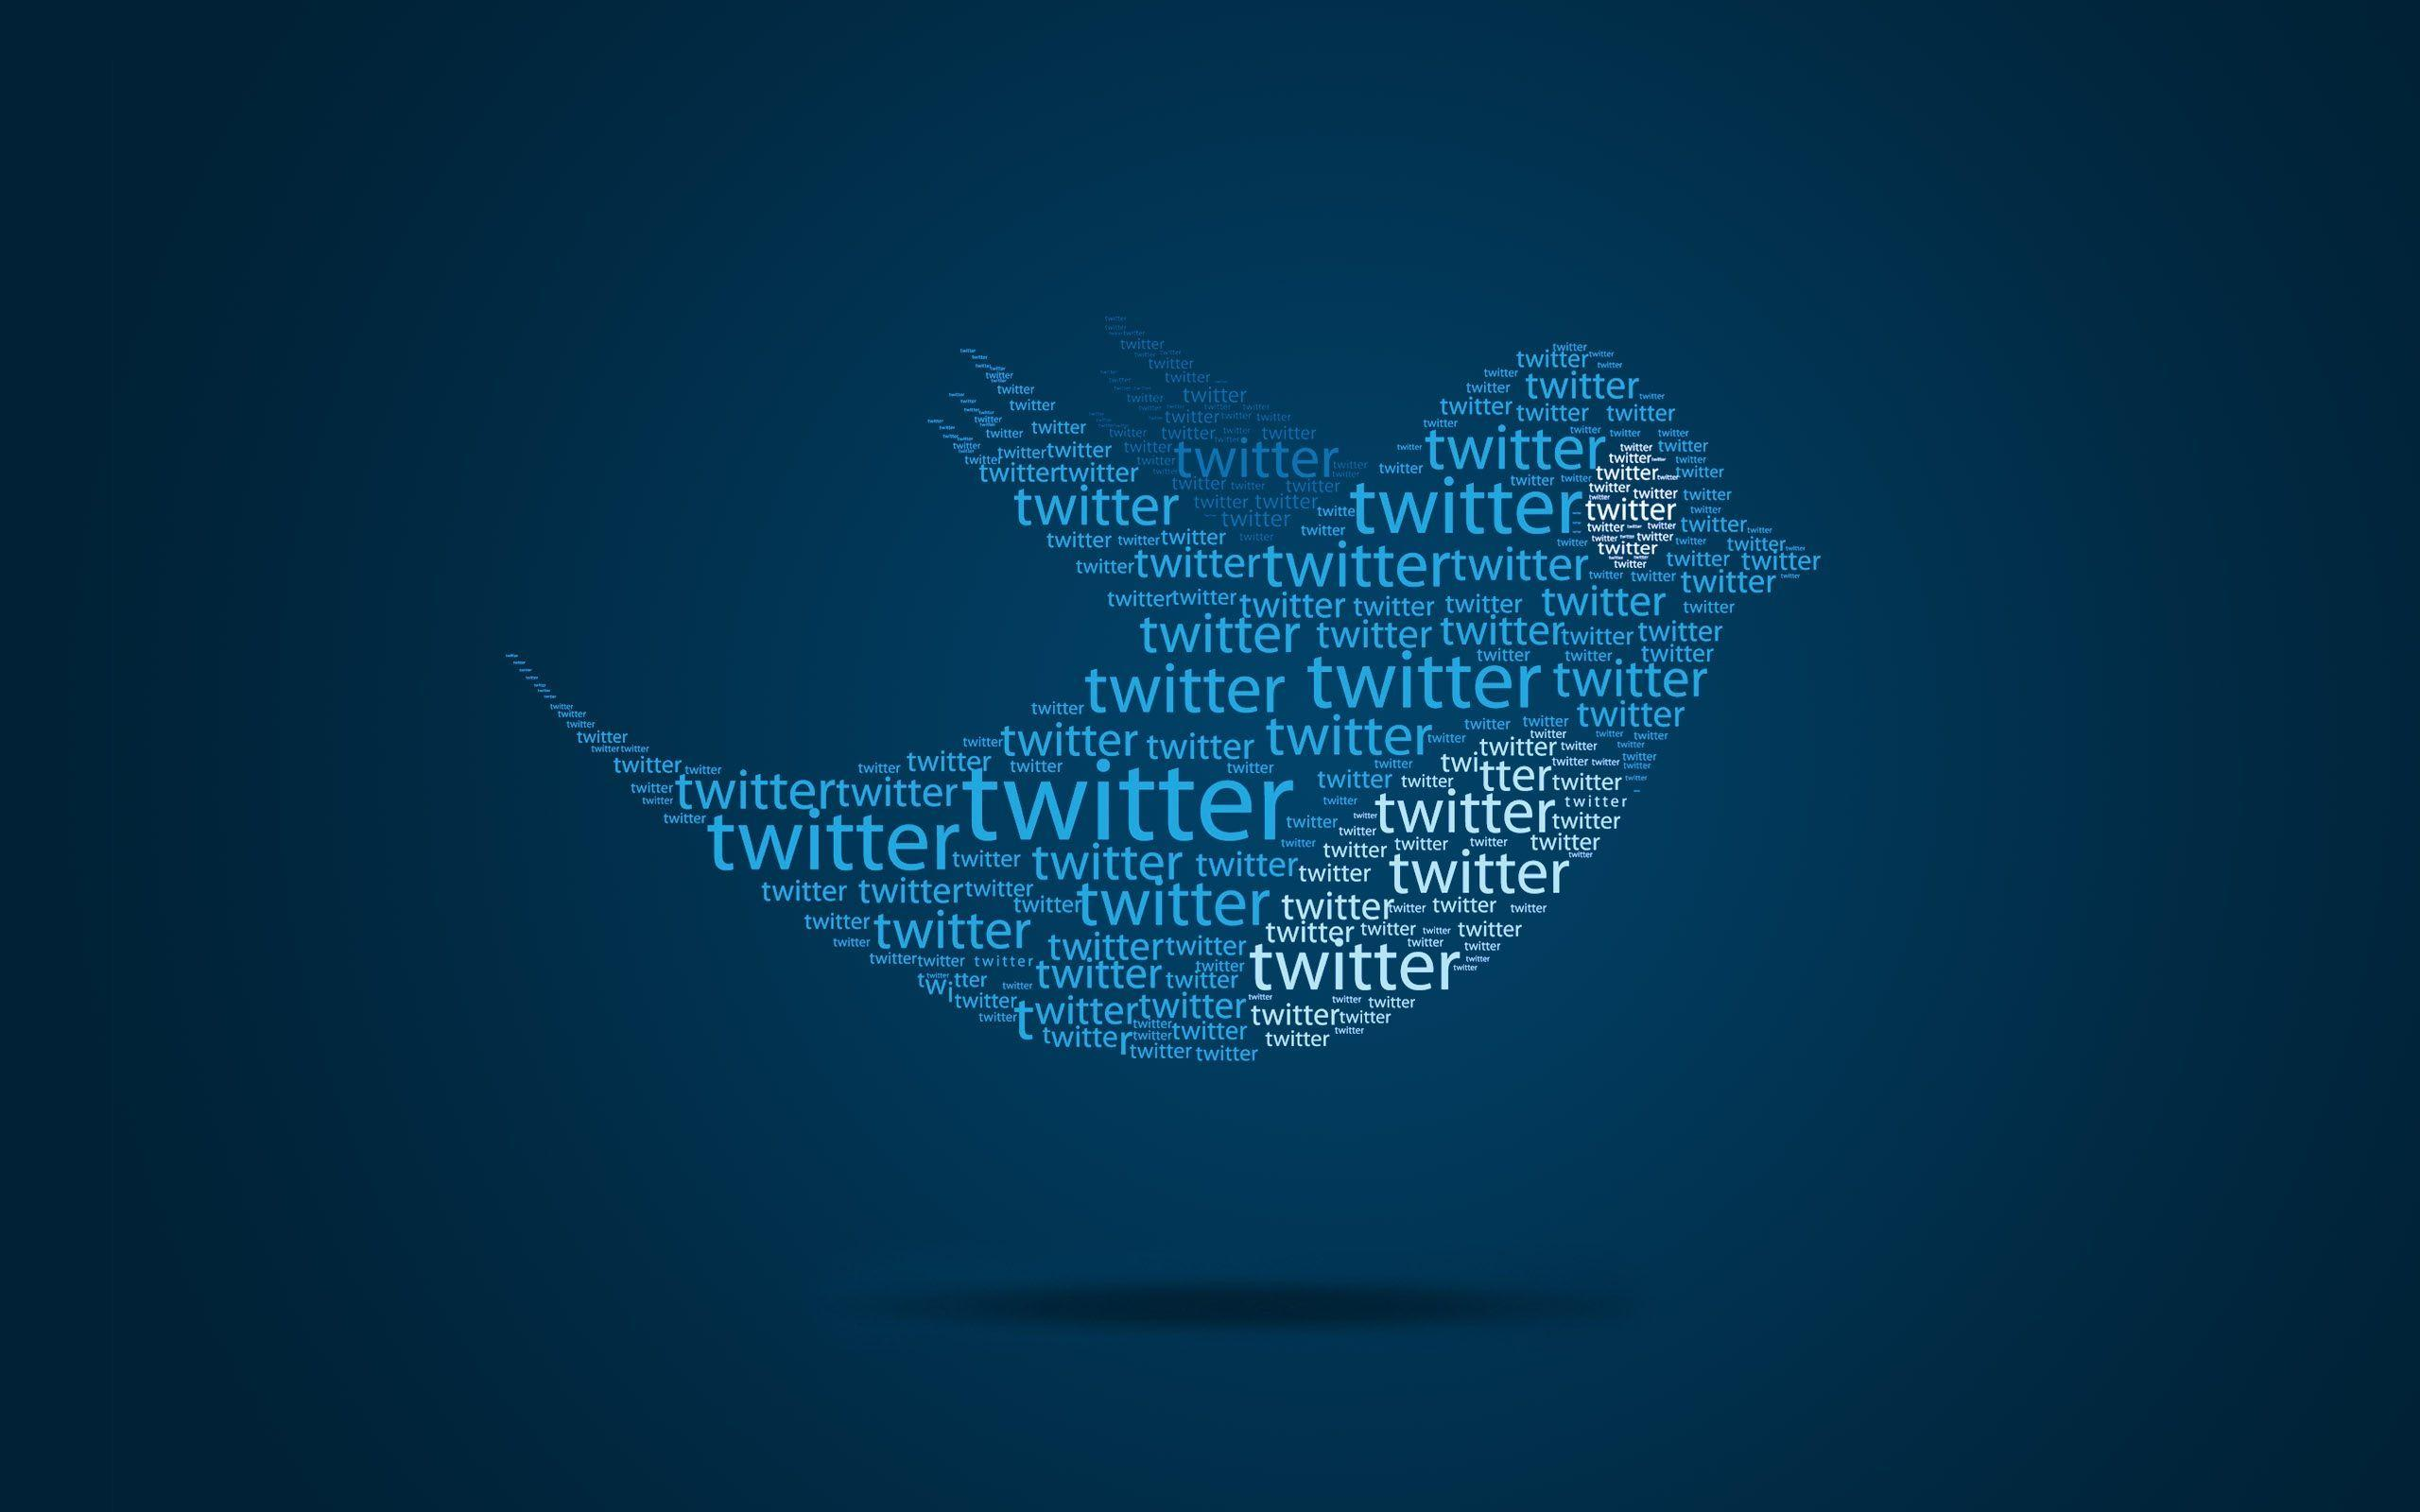

## Objective:
The goal is to build an automated Named Entity Recognition (NER) system that can detect entities like people, organizations, locations, movies, etc., from tweets — without relying on hashtags or explicit tags.
This helps Twitter analyze trending topics, user interests, and public sentiment automatically.

### Applications / Where this can be used:

  - **Trend detection:** Automatically group tweets around real-world entities (e.g., “Taylor Swift,” “New York,” “Netflix”).

  - **Content moderation:** Identify sensitive entities or topics.

  - **Market analysis:** Detect product or brand mentions.

  - **Recommendation systems:** Suggest related content or ads based on detected entities.
  - **Information extraction:** Build structured knowledge bases from unstructured social data.

## Dataset Information

  - **Dataset Name:** Twitter Named Entity Recognition Dataset

  - **Source:** [https://drive.google.com/drive/folders/14IgdWzzpjp166rhNhp9UFenjUp_czaGo]

  - **File Format:** Text file (.txt) in CoNLL BIO format

  - **Language:** English

  - **Number of Categories (Entities):** 10 fine-grained NER categories

    - person

    - geo-location

    - company

    - facility

    - product

    - music artist

    - movie

    - sports team

    - tv show

    - other

  - **Data Structure:**
  
    Each tweet is represented in **CoNLL format**, which means:

    - Each line contains a single word and its corresponding NER label.

    - Sentences (tweets) are separated by a blank line.

    - The first element in each line is the word, and the last element is its label.

Example Format

    Consider the sentences:

    “Harry Potter was a student living in London”
    “Albus Dumbledore went to the Disney World”

    They are represented in the dataset as:
    """Harry B-PER
    Potter I-PER
    was O
    a O
    student O
    living O
    in O
    London B-geo-loc

    Albus B-PER
    Dumbledore I-PER
    went O
    to O
    the O
    Disney B-facility
    World I-facility
    """


## Loading the Dataset

In [10]:
# Importing required libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
from google.colab import files
uploaded = files.upload()

Saving wnut 16test.txt (1).conll to wnut 16test.txt (1) (1).conll
Saving wnut 16.txt (1).conll to wnut 16.txt (1) (1).conll


In [12]:
def read_conll_file(filepath):
    sentences, sentence = [], []
    with open(filepath, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:  # blank line → new sentence
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                parts = line.split()
                word, tag = parts[0], parts[-1]
                sentence.append((word, tag))
    if sentence:
        sentences.append(sentence)
    return sentences

In [13]:
# Loading train and test data
train_data = read_conll_file("/content/wnut 16.txt (1).conll")
test_data = read_conll_file("/content/wnut 16test.txt (1) (1).conll")

In [14]:
print(f"Train sentences: {len(train_data)}")
print(f"Test sentences: {len(test_data)}")

Train sentences: 2394
Test sentences: 3850


In [15]:
print("First sentence example:\n", train_data[0][:10])

First sentence example:
 [('@SammieLynnsMom', 'O'), ('@tg10781', 'O'), ('they', 'O'), ('will', 'O'), ('be', 'O'), ('all', 'O'), ('done', 'O'), ('by', 'O'), ('Sunday', 'O'), ('trust', 'O')]


In [16]:
print("First sentence example:\n", test_data[0][:10])

First sentence example:
 [('New', 'B-other'), ('Orleans', 'I-other'), ('Mother', 'I-other'), ("'s", 'I-other'), ('Day', 'I-other'), ('Parade', 'I-other'), ('shooting', 'O'), ('.', 'O'), ('One', 'O'), ('of', 'O')]


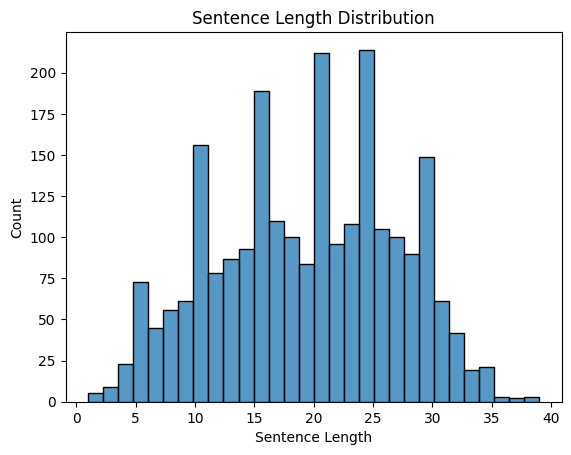

In [17]:
# Sentence length distribution
sent_lengths = [len(s) for s in train_data]
sns.histplot(sent_lengths, bins=30)
plt.title("Sentence Length Distribution")
plt.xlabel("Sentence Length")
plt.ylabel("Count")
plt.show()

In [18]:
# Unique tags
tags = list(set(tag for s in train_data for _, tag in s))
print("Unique Tags:", tags)

Unique Tags: ['O', 'B-other', 'B-geo-loc', 'I-musicartist', 'B-movie', 'B-company', 'B-product', 'I-company', 'I-facility', 'B-musicartist', 'I-other', 'B-sportsteam', 'I-movie', 'I-geo-loc', 'B-facility', 'B-tvshow', 'I-person', 'I-product', 'I-tvshow', 'B-person', 'I-sportsteam']


- The distribution is roughly bell-shaped but not perfectly normal — it looks multi-modal, with several peaks (e.g., around 10, 20, 25, 30 tokens).
Most sentences are between 10–30 tokens long.
- Sentences longer than ~35 tokens are few.
That means truncating to 40 tokens won’t lose much information.
- A noticeable number of sentences under 10 tokens — possibly short headlines or single-entity sentences.

## Training a LSTM + Softmax Classifier

Since CRF cannot be installed with my tensorflow version-2.19, I will train LSTM model and replace CRF with softmax classifier.

In [ ]:
# !pip install gensim

In [ ]:
# Importing libraries
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, TimeDistributed
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
import json


# Convert train & test into sentences + tags
train_sentences = [[w for w, t in s] for s in train_data]
train_tags      = [[t for w, t in s] for s in train_data]

test_sentences = [[w for w, t in s] for s in test_data]
test_tags      = [[t for w, t in s] for s in test_data]


# Train Word2Vec on train sentences only
w2v_dim = 100

w2v = Word2Vec(
    sentences=train_sentences,
    vector_size=w2v_dim,
    window=5,
    min_count=1,
    workers=4
)
print("Word2Vec vocab size:", len(w2v.wv))


# Build word2idx
words = list(w2v.wv.key_to_index.keys())

word2idx = {w: i+2 for i, w in enumerate(words)}
word2idx["PAD"] = 0
word2idx["UNK"] = 1


# Build tag2idx
tags = sorted(list(set(tag for sent in (train_tags+test_tags) for tag in sent)))
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: t for t, i in tag2idx.items()}


# Encode train/test
max_len = 50

def encode_words(sentences):
    return pad_sequences(
        [[word2idx.get(w, 1) for w in s] for s in sentences],
        maxlen=max_len, padding="post"
    )

def encode_tags(tags_list):
    y = [[tag2idx[t] for t in tags] for tags in tags_list]
    y = pad_sequences(y, maxlen=max_len, padding="post")
    return np.array([to_categorical(seq, num_classes=len(tag2idx)) for seq in y])

X_train = encode_words(train_sentences)
y_train = encode_tags(train_tags)

X_test = encode_words(test_sentences)
y_test = encode_tags(test_tags)


# Build Embedding Matrix
embedding_matrix = np.zeros((len(word2idx), w2v_dim))

for word, idx in word2idx.items():
    if word in w2v.wv:
        embedding_matrix[idx] = w2v.wv[word]


# Build BiLSTM Model
def build_model():
    inp = Input(shape=(max_len,))

    emb = Embedding(
        input_dim=len(word2idx),
        output_dim=w2v_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        mask_zero=True,
        trainable=False
    )(inp)

    x = Bidirectional(
        LSTM(128, return_sequences=True, dropout=0.3)
    )(emb)

    x = TimeDistributed(Dense(64, activation="relu"))(x)
    out = TimeDistributed(Dense(len(tag2idx), activation="softmax"))(x)

    model = Model(inp, out)
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


model = build_model()
model.summary()


# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32
)


# Predict & Evaluate
y_pred_prob = model.predict(X_test)

y_true_flat = []
y_pred_flat = []

for true_seq, pred_seq in zip(y_test, y_pred_prob):
    for t, p in zip(true_seq, pred_seq):
        true_idx = np.argmax(t)
        pred_idx = np.argmax(p)

        if true_idx == tag2idx["PAD"]:
            continue

        y_true_flat.append(idx2tag[true_idx])
        y_pred_flat.append(idx2tag[pred_idx])

print("\nClassification Report:")
print(classification_report(y_true_flat, y_pred_flat))


# Save model & mappings
model.save("ner_bilstm_w2v.keras")
json.dump(word2idx, open("word2idx.json","w"))
json.dump(tag2idx, open("tag2idx.json","w"))


# Inference
def predict_sentence(words):
    seq = [word2idx.get(w, 1) for w in words]
    seq = pad_sequences([seq], maxlen=max_len, padding="post")

    probs = model.predict(seq)[0]
    preds = [idx2tag[np.argmax(p)] for p in probs[:len(words)]]

    return list(zip(words, preds))

print("\nInference Example:")
print(predict_sentence(["John", "went", "to", "California"]))


Word2Vec vocab size: 10586


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 50, 100)   │  1,058,800 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 50)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 50, 256)   │    234,496 │ embedding_2[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 50, 64)    │     16,448 │ bidirectional_2[… │
│ (TimeDistributed)   │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 50, 22)    │      1,430 │ time_distributed… │
│ (TimeDistributed)   │                   │            │ not_equal_2[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,311,174 (5.00 MB)

 Trainable params: 252,374 (985.84 KB)

 Non-trainable params: 1,058,800 (4.04 MB)

Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step - accuracy: 0.3790 - loss: 1.0211 - val_accuracy: 0.3512 - val_loss: 0.3556
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - accuracy: 0.3677 - loss: 0.3535 - val_accuracy: 0.3512 - val_loss: 0.3221
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 213ms/step - accuracy: 0.3699 - loss: 0.3293 - val_accuracy: 0.3512 - val_loss: 0.3155
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 201ms/step - accuracy: 0.3706 - loss: 0.3326 - val_accuracy: 0.3512 - val_loss: 0.3108
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - accuracy: 0.3701 - loss: 0.2978 - val_accuracy: 0.3512 - val_loss: 0.3066
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - accuracy: 0.3768 - loss: 0.3035 - val_accuracy: 0.3512 - val_loss: 0.3065
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - accuracy: 0.3707 - loss: 0.3153 - val_accuracy: 0.3512 - val_loss: 0.3029
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 14s 202ms/step - accuracy: 0.3637 - loss: 0.3010 - val_accu

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

    B-company       0.00      0.00      0.00       621
   B-facility       0.00      0.00      0.00       253
    B-geo-loc       0.00      0.00      0.00       882
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.00      0.00      0.00       191
      B-other       0.00      0.00      0.00       584
     B-person       0.00      0.00      0.00       482
    B-product       0.00      0.00      0.00       246
 B-sportsteam       0.00      0.00      0.00       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       0.00      0.00      0.00       265
   I-facility       0.00      0.00      0.00       366
    I-geo-loc       0.00      0.00      0.00       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       0.00      0.00      0.00       140
      I-other       0.00      0.00      0.00       556
     I-person       0.00      0.00      0.00       300
    I-pro

- The model is predicting almost only "O" for every token. This means **the model failed to learn any named entities**.

### Why it happened?
-  Model is underfitting

  - Small dataset + imbalanced labels → no learning.

-  Word2Vec is not strong enough

  - Word2Vec gives general similarity but does NOT capture entity boundaries well.

- BiLSTM (no CRF) is too weak for NER

  - BiLSTM alone usually collapses to predicting O.


# BiLSTM NER Model with Pretrained GloVe Embeddings

Let's implement a BiLSTM model using GloVe embeddings.

In [1]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [ ]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import json



# Extract vocabulary
words = list(set(w for s in train_data for w, _ in s))
tags  = list(set(t for s in train_data for _, t in s))

word2idx = {w: i+2 for i, w in enumerate(words)}
word2idx["PAD"] = 0
word2idx["UNK"] = 1

tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

idx2tag = {v: k for k, v in tag2idx.items()}

print("Vocab size:", len(word2idx))
print("Tags:", tag2idx)


# Encode sentences
def encode(data):
    X, y = [], []
    for sent in data:
        X.append([word2idx.get(w, 1) for w, _ in sent])
        y.append([tag2idx[t] for _, t in sent])
    return X, y

X_train_raw, y_train_raw = encode(train_data)
X_test_raw,  y_test_raw  = encode(test_data)


# Padding
max_len = 50
X_train = pad_sequences(X_train_raw, maxlen=max_len, padding="post")
X_test  = pad_sequences(X_test_raw,  maxlen=max_len, padding="post")
y_train = pad_sequences(y_train_raw, maxlen=max_len, padding="post")
y_test  = pad_sequences(y_test_raw,  maxlen=max_len, padding="post")

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(tag2idx))
y_test  = tf.keras.utils.to_categorical(y_test,  num_classes=len(tag2idx))


# Load Pretrained GloVe
embedding_dim = 100
embeddings_index = {}

with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = vec

print("Loaded GloVe vectors:", len(embeddings_index))


# Create Embedding Matrix
embedding_matrix = np.zeros((len(word2idx), embedding_dim))

for word, i in word2idx.items():
    vec = embeddings_index.get(word.lower())
    if vec is not None:
        embedding_matrix[i] = vec
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

print("Embedding matrix shape:", embedding_matrix.shape)


# Build BiLSTM Model
def build_model():
    input_layer = Input(shape=(max_len,))

    embedding_layer = Embedding(
        input_dim=len(word2idx),
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        mask_zero=True,
        trainable=True
    )(input_layer)

    lstm = Bidirectional(
        LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)
    )(embedding_layer)

    td = TimeDistributed(Dense(128, activation="relu"))(lstm)
    output_layer = TimeDistributed(
        Dense(len(tag2idx), activation="softmax")
    )(td)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    return model

model = build_model()
model.summary()


# Splitting the training data to training and validation data
X_train2, X_val, y_train2, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

history = model.fit(
    X_train2, y_train2,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=25,
    verbose=1
)


# Prediction & Evaluation
y_pred_prob = model.predict(X_test)

y_true_flat = []
y_pred_flat = []

for true_seq, pred_seq in zip(y_test, y_pred_prob):
    for t, p in zip(true_seq, pred_seq):
        true_idx = np.argmax(t)
        pred_idx = np.argmax(p)

        if true_idx == tag2idx["PAD"]:
            continue

        y_true_flat.append(idx2tag[true_idx])
        y_pred_flat.append(idx2tag[pred_idx])

print("\nClassification Report")
print(classification_report(y_true_flat, y_pred_flat))


# Save Model & Mappings
model.save("ner_bilstm_glove.keras")
json.dump(word2idx, open("word2idx.json","w"))
json.dump(tag2idx, open("tag2idx.json","w"))


# Inference function
def predict_sentence(words):
    seq = [word2idx.get(w, 1) for w in words]
    seq = pad_sequences([seq], maxlen=max_len, padding="post")
    probs = model.predict(seq)[0]

    preds = [idx2tag[np.argmax(p)] for p in probs[:len(words)]]
    return list(zip(words, preds))

print("\nInference example:")
print(predict_sentence(["John", "went", "to", "California"]))


Vocab size: 10588
Tags: {'I-facility': 1, 'I-other': 2, 'I-tvshow': 3, 'B-tvshow': 4, 'B-company': 5, 'B-movie': 6, 'B-musicartist': 7, 'I-company': 8, 'I-sportsteam': 9, 'B-sportsteam': 10, 'I-movie': 11, 'B-other': 12, 'I-person': 13, 'B-product': 14, 'B-facility': 15, 'O': 16, 'I-product': 17, 'I-musicartist': 18, 'B-geo-loc': 19, 'I-geo-loc': 20, 'B-person': 21, 'PAD': 0}
Loaded GloVe vectors: 400000
Embedding matrix shape: (10588, 100)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 50, 100)   │  1,058,800 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 50)        │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 50, 512)   │    731,136 │ embedding_1[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 50, 128)   │     65,664 │ bidirectional_1[… │
│ (TimeDistributed)   │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 50, 22)    │      2,838 │ time_distributed… │
│ (TimeDistributed)   │                   │            │ not_equal_1[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,858,438 (7.09 MB)

 Trainable params: 1,858,438 (7.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 100s 725ms/step - accuracy: 0.3805 - loss: 0.6634 - val_accuracy: 0.3664 - val_loss: 0.2983
Epoch 2/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 84s 698ms/step - accuracy: 0.3727 - loss: 0.2544 - val_accuracy: 0.3690 - val_loss: 0.2440
Epoch 3/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 141s 696ms/step - accuracy: 0.3668 - loss: 0.2133 - val_accuracy: 0.3699 - val_loss: 0.2183
Epoch 4/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 86s 716ms/step - accuracy: 0.3674 - loss: 0.1649 - val_accuracy: 0.3711 - val_loss: 0.1980
Epoch 5/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 82s 687ms/step - accuracy: 0.3707 - loss: 0.1479 - val_accuracy: 0.3713 - val_loss: 0.1995
Epoch 6/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 143s 698ms/step - accuracy: 0.3789 - loss: 0.1273 - val_accuracy: 0.3699 - val_loss: 0.2008
Epoch 7/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 88s 733ms/step - accuracy: 0.3772 - loss: 0.0885 - val_accuracy: 0.3660 - val_loss: 0.2222
Epoch 8/25
120/120 ━━━━━━━━━━━━━━━━━━━━ 84s 703ms/step - accuracy: 0.3760 - loss

- We can see that the inference is right, but model is still biased towards predicting O.
- Precision: 0.92, Recall: 1.00, F1: 0.96.

Let's implement a BiLSTM + CRF model using GloVe embeddings.

# BiLSTM–CRF Model for Named Entity Recognition (NER) Using Pretrained GloVe Embeddings

### Why BiLSTM?

- A Bi-directional LSTM captures context from both past (left) and future (right) words in a sentence.

- This is essential for NER because meaning depends on surrounding words, e.g.:

  - "Apple launched…" → Organization

  - "He ate an apple" → Fruit
- Benefits:

  - Learns long-range dependencies

  - Handles variable-length sequences

  - Captures richer semantic context than traditional RNNs

### Why CRF?

- A Conditional Random Field ensures the final predicted tag sequence is consistent and valid.

- Neural networks predict each tag independently, but CRF learns tag transition probabilities, e.g.:

  - I-PER cannot follow B-ORG

  - I-LOC must follow B-LOC

- Benefits:

  - Enforces linguistic constraints

  - Provides globally optimal tag sequences

  - Reduces invalid or noisy predictions

### BiLSTM + CRF

- This combination is widely used because:

  - BiLSTM extracts contextual features

  - CRF produces structured, globally optimized tag sequences
  
- Together, they provide strong performance for sequence labeling tasks by combining deep contextual features with structured prediction.

In [2]:
# !pip install git+https://github.com/kmkurn/pytorch-crf.git

In [ ]:
# Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchcrf import CRF
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import json


# Extract vocabulary
words = list(set(w for s in train_data for w, _ in s))
tags = list(set(t for s in train_data for _, t in s))

word2idx = {w: i+2 for i, w in enumerate(words)}
word2idx["PAD"] = 0
word2idx["UNK"] = 1

tag2idx = {t: i for i, t in enumerate(tags)}
tag2idx["PAD"] = len(tag2idx)  # pad tag for CRF
idx2tag = {v: k for k, v in tag2idx.items()}

# Encode sentences
def encode(data):
    X, y = [], []
    for sent in data:
        X.append([word2idx.get(w, 1) for w, _ in sent])
        y.append([tag2idx[t] for _, t in sent])
    return X, y

X_train_raw, y_train_raw = encode(train_data)
X_test_raw, y_test_raw = encode(test_data)

# Padding
max_len = 50
def pad_sequences(seqs, max_len, pad_value=0):
    return [seq + [pad_value]*(max_len-len(seq)) if len(seq)<max_len else seq[:max_len] for seq in seqs]

X_train = pad_sequences(X_train_raw, max_len)
y_train = pad_sequences(y_train_raw, max_len, pad_value=tag2idx["PAD"])
X_test  = pad_sequences(X_test_raw, max_len)
y_test  = pad_sequences(y_test_raw, max_len, pad_value=tag2idx["PAD"])


# Load GloVe Embeddings
embedding_dim = 100
embeddings_index = {}
with open("glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = vec


# Create embedding matrix
embedding_matrix = np.zeros((len(word2idx), embedding_dim))
for word, i in word2idx.items():
    vec = embeddings_index.get(word.lower())
    if vec is not None:
        embedding_matrix[i] = vec
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

# Convert to torch tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float)


# Create Dataset Class
class NERDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = NERDataset(X_train, y_train)
test_dataset  = NERDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)


# Define BiLSTM + CRF Model
class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim, embeddings=None):
        super(BiLSTM_CRF, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if embeddings is not None:
            self.embedding.weight.data.copy_(embeddings)
            self.embedding.weight.requires_grad = True  # fine-tune embeddings

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )
        self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, x, tags=None, mask=None):
        emb = self.embedding(x)
        lstm_out, _ = self.lstm(emb)
        emissions = self.hidden2tag(lstm_out)
        if tags is not None:
            loss = -self.crf(emissions, tags, mask=mask, reduction='mean')
            return loss
        else:
            pred = self.crf.decode(emissions, mask=mask)
            return pred

# Instantiate model
hidden_dim = 256
model = BiLSTM_CRF(len(word2idx), len(tag2idx), embedding_dim, hidden_dim, embeddings=embedding_matrix)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        mask = X_batch != word2idx["PAD"]
        loss = model(X_batch, tags=y_batch, mask=mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")


# Evaluation
model.eval()
y_true_flat = []
y_pred_flat = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        mask = X_batch != word2idx["PAD"]
        predictions = model(X_batch, mask=mask)
        for true_seq, pred_seq, m in zip(y_batch, predictions, mask):
            for t, p, keep in zip(true_seq, pred_seq, m):
                if not keep:
                    continue
                y_true_flat.append(idx2tag[t.item()])
                y_pred_flat.append(idx2tag[p])

print("\nClassification Report:")
print(classification_report(y_true_flat, y_pred_flat))


# Inference Function
def predict_sentence(words):
    model.eval()
    seq = [word2idx.get(w, 1) for w in words]
    seq_padded = pad_sequences([seq], max_len)
    X_tensor = torch.tensor(seq_padded, dtype=torch.long).to(device)
    mask = X_tensor != word2idx["PAD"]
    with torch.no_grad():
        pred = model(X_tensor, mask=mask)[0]
    return list(zip(words, [idx2tag[p] for p in pred[:len(words)]]))

print("\nInference Example:")
print(predict_sentence(["John", "went", "to", "California"]))

Epoch 1/10, Loss: 8.0883
Epoch 2/10, Loss: 4.4303
Epoch 3/10, Loss: 3.3302
Epoch 4/10, Loss: 2.5682
Epoch 5/10, Loss: 1.9387
Epoch 6/10, Loss: 1.4077
Epoch 7/10, Loss: 1.0162
Epoch 8/10, Loss: 0.7002
Epoch 9/10, Loss: 0.4922
Epoch 10/10, Loss: 0.3531

Classification Report:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

    B-company       0.71      0.12      0.20       621
   B-facility       0.54      0.19      0.28       253
    B-geo-loc       0.67      0.27      0.39       882
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.00      0.00      0.00       191
      B-other       0.29      0.05      0.08       584
     B-person       0.43      0.20      0.27       482
    B-product       0.40      0.03      0.06       246
 B-sportsteam       0.40      0.01      0.03       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       0.90      0.03      0.07       265
   I-facility       0.58      0.16      0.25       366
    I-geo-loc       0.19      0.02      0.04       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       0.00      0.00      0.00       140
      I-other       0.52      0.05      0.09       556
     I-person       0.57      0.19      0.28       300
    I-pro

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- The model shows **very high accuracy (0.91)** mainly because it predicts the **‘O’ (non-entity)** tag almost perfectly. However, most actual entity classes (like person, company, product, movie, etc.) have **very low precision, recall, and F1-scores**, meaning the model is not recognizing named entities well.

- The inference example is correct, showing the model can identify simple entities, but overall it is **underfitting** and needs more training, better embeddings, or a stronger model like **BERT**.

# End-to-End BERT NER Training and Inference Pipeline

In [ ]:
# Importing the libraries
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForTokenClassification, get_scheduler
import numpy as np
from torch.optim import AdamW
from tqdm import tqdm
import json
import os

from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Convert dataset
def convert_dataset(raw):
    return [
        {"tokens": [w for w, l in sent], "labels": [l for w, l in sent]}
        for sent in raw
    ]

train = convert_dataset(train_data)
test  = convert_dataset(test_data)


# Label maps
all_labels = sorted(list({label for sent in train+test for label in sent["labels"]}))
label2id = {l:i for i,l in enumerate(all_labels)}
id2label = {i:l for l,i in label2id.items()}

json.dump(label2id, open("label2id.json","w"))
json.dump(id2label, open("id2label.json","w"))


# 4) Tokenizer
model_name = "bert-base-cased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)


# Tokenization + proper subword alignment
def tokenize_and_align_labels(dataset):
    input_ids, attn_masks, label_ids = [], [], []

    for ex in dataset:
        enc = tokenizer(
            ex["tokens"], is_split_into_words=True,
            truncation=True, padding="max_length", max_length=80
        )

        word_ids = enc.word_ids()
        prev_word = None
        labels = []

        for w in word_ids:
            if w is None:
                labels.append(-100)
            elif w != prev_word:
                labels.append(label2id[ex["labels"][w]])
            else:
                labels.append(-100)
            prev_word = w

        input_ids.append(enc["input_ids"])
        attn_masks.append(enc["attention_mask"])
        label_ids.append(labels)

    return {
        "input_ids": torch.tensor(input_ids),
        "attention_mask": torch.tensor(attn_masks),
        "labels": torch.tensor(label_ids)
    }

train_enc = tokenize_and_align_labels(train)
test_enc  = tokenize_and_align_labels(test)


# Dataset
class NERDataset(Dataset):
    def __init__(self, enc): self.enc = enc
    def __len__(self): return len(self.enc["input_ids"])
    def __getitem__(self, i): return {k:v[i] for k,v in self.enc.items()}

train_dataset = NERDataset(train_enc)
test_dataset  = NERDataset(test_enc)


# Hyperparams
batch_sizes = [8,16]
learning_rates = [3e-5, 5e-5]
epochs_list = [3, 5]

early_patience = 2
best_model_path = "best_bert_ner_model"
os.makedirs(best_model_path, exist_ok=True)


# Training Loop + Evaluation
for batch_size in batch_sizes:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size)

    for lr in learning_rates:
        for num_epochs in epochs_list:

            print(f"\n=== TRAINING: batch={batch_size}, lr={lr}, epochs={num_epochs} ===")

            model = BertForTokenClassification.from_pretrained(
                model_name,
                num_labels=len(label2id)
            ).to(device)

            optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
            num_steps = len(train_loader)*num_epochs

            scheduler = get_scheduler(
                "linear", optimizer=optimizer,
                num_warmup_steps=int(0.1*num_steps),
                num_training_steps=num_steps
            )

            best_val_loss = float("inf")
            no_improve = 0

            for epoch in range(num_epochs):
                # ---- Train ----
                model.train()
                total_loss = 0

                for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
                    batch = {k:v.to(device) for k,v in batch.items()}

                    out = model(**batch)
                    loss = out.loss

                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                    scheduler.step()
                    optimizer.zero_grad()

                    total_loss += loss.item()

                train_loss = total_loss / len(train_loader)

                # ---- Validation Loss ----
                model.eval()
                val_loss = 0
                with torch.no_grad():
                    for batch in test_loader:
                        batch = {k:v.to(device) for k,v in batch.items()}
                        out = model(**batch)
                        val_loss += out.loss.item()
                val_loss /= len(test_loader)

                print(f"Epoch {epoch+1} | Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f}")

                # ---- Early Stopping ----
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    no_improve = 0
                    model.save_pretrained(best_model_path)
                    tokenizer.save_pretrained(best_model_path)
                else:
                    no_improve += 1
                    if no_improve >= early_patience:
                        print("Early stopping triggered.")
                        break

                # ---- Evaluation Metrics ----
                all_preds, all_labels = [], []

                with torch.no_grad():
                    for batch in test_loader:
                        batch = {k:v.to(device) for k,v in batch.items()}
                        out = model(**batch)
                        preds = torch.argmax(out.logits, dim=-1)

                        all_preds.extend(preds.cpu().numpy().flatten())
                        all_labels.extend(batch["labels"].cpu().numpy().flatten())

                # Remove -100 labels
                y_true, y_pred = [], []
                for p,l in zip(all_preds, all_labels):
                    if l != -100:
                        y_true.append(l)
                        y_pred.append(p)

                # Classification report
                report = classification_report(
                    y_true, y_pred,
                    target_names=[id2label[i] for i in range(len(id2label))],
                    zero_division=0
                )
                acc = accuracy_score(y_true, y_pred)

                print("\nClassification Report:\n", report)
                print("Accuracy:", acc)


                # Save results to file
                with open("evaluation_results.txt", "a") as f:
                    f.write(f"\nEpoch {epoch+1}\n")
                    f.write(report)
                    f.write(f"\nAccuracy: {acc}\n")
                    # f.write(f"\nConfusion Matrix:\n{cm}\n")

# Load best model
model = BertForTokenClassification.from_pretrained(best_model_path).to(device)
tokenizer = BertTokenizerFast.from_pretrained(best_model_path)
id2label = json.load(open("id2label.json"))


=== TRAINING: batch=8, lr=3e-05, epochs=3 ===


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 300/300 [00:45<00:00,  6.63it/s]


Epoch 1 | Train Loss=0.4744 | Val Loss=0.3385

Classification Report:
                precision    recall  f1-score   support

    B-company       0.72      0.21      0.32       621
   B-facility       0.11      0.02      0.03       253
    B-geo-loc       0.44      0.69      0.54       881
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.00      0.00      0.00       191
      B-other       0.64      0.02      0.03       584
     B-person       0.48      0.82      0.60       482
    B-product       0.50      0.01      0.02       246
 B-sportsteam       0.00      0.00      0.00       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       0.00      0.00      0.00       265
   I-facility       0.60      0.48      0.53       366
    I-geo-loc       0.19      0.02      0.03       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       0.00      0.00      0.00       140
      I-other       0.39      0.06      0.10    

Epoch 2: 100%|██████████| 300/300 [00:44<00:00,  6.76it/s]


Epoch 2 | Train Loss=0.1091 | Val Loss=0.3009

Classification Report:
                precision    recall  f1-score   support

    B-company       0.68      0.48      0.56       621
   B-facility       0.44      0.28      0.34       253
    B-geo-loc       0.57      0.77      0.65       881
      B-movie       0.67      0.06      0.11        34
B-musicartist       0.43      0.02      0.03       191
      B-other       0.42      0.27      0.33       584
     B-person       0.60      0.77      0.68       482
    B-product       0.21      0.02      0.04       246
 B-sportsteam       0.65      0.33      0.43       147
     B-tvshow       1.00      0.03      0.06        33
    I-company       0.50      0.01      0.01       265
   I-facility       0.62      0.58      0.60       366
    I-geo-loc       0.50      0.54      0.52       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       0.41      0.06      0.11       140
      I-other       0.33      0.49      0.39    

Epoch 3: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s]


Epoch 3 | Train Loss=0.0612 | Val Loss=0.3158

Classification Report:
                precision    recall  f1-score   support

    B-company       0.73      0.50      0.59       621
   B-facility       0.47      0.30      0.36       253
    B-geo-loc       0.62      0.72      0.67       881
      B-movie       0.40      0.06      0.10        34
B-musicartist       0.29      0.02      0.04       191
      B-other       0.40      0.33      0.37       584
     B-person       0.56      0.81      0.67       482
    B-product       0.26      0.10      0.14       246
 B-sportsteam       0.69      0.36      0.47       147
     B-tvshow       1.00      0.03      0.06        33
    I-company       0.82      0.05      0.10       265
   I-facility       0.66      0.58      0.62       366
    I-geo-loc       0.52      0.54      0.53       219
      I-movie       0.31      0.08      0.13        48
I-musicartist       0.33      0.09      0.14       140
      I-other       0.32      0.45      0.37    

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 300/300 [00:42<00:00,  7.08it/s]


Epoch 1 | Train Loss=0.5122 | Val Loss=0.3144

Classification Report:
                precision    recall  f1-score   support

    B-company       0.51      0.33      0.40       621
   B-facility       0.48      0.16      0.24       253
    B-geo-loc       0.48      0.77      0.59       881
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.00      0.00      0.00       191
      B-other       0.59      0.08      0.14       584
     B-person       0.57      0.76      0.65       482
    B-product       0.00      0.00      0.00       246
 B-sportsteam       0.39      0.31      0.34       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       0.00      0.00      0.00       265
   I-facility       0.64      0.46      0.53       366
    I-geo-loc       0.16      0.04      0.06       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       0.00      0.00      0.00       140
      I-other       0.42      0.43      0.42    

Epoch 2: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s]


Epoch 2 | Train Loss=0.1126 | Val Loss=0.2826

Classification Report:
                precision    recall  f1-score   support

    B-company       0.65      0.58      0.62       621
   B-facility       0.49      0.31      0.38       253
    B-geo-loc       0.64      0.71      0.68       881
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.34      0.06      0.10       191
      B-other       0.57      0.23      0.33       584
     B-person       0.63      0.75      0.69       482
    B-product       0.50      0.09      0.15       246
 B-sportsteam       0.68      0.31      0.42       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       1.00      0.03      0.05       265
   I-facility       0.67      0.53      0.59       366
    I-geo-loc       0.52      0.60      0.56       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       0.32      0.16      0.21       140
      I-other       0.49      0.48      0.49    

Epoch 3: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s]


Epoch 3 | Train Loss=0.0580 | Val Loss=0.3106

Classification Report:
                precision    recall  f1-score   support

    B-company       0.79      0.46      0.58       621
   B-facility       0.49      0.33      0.39       253
    B-geo-loc       0.67      0.72      0.69       881
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.37      0.08      0.14       191
      B-other       0.48      0.34      0.40       584
     B-person       0.52      0.81      0.64       482
    B-product       0.22      0.22      0.22       246
 B-sportsteam       0.67      0.38      0.49       147
     B-tvshow       0.20      0.03      0.05        33
    I-company       0.80      0.14      0.24       265
   I-facility       0.66      0.52      0.58       366
    I-geo-loc       0.56      0.59      0.58       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       0.31      0.10      0.15       140
      I-other       0.40      0.54      0.46    

Epoch 4: 100%|██████████| 300/300 [00:41<00:00,  7.22it/s]


Epoch 4 | Train Loss=0.0320 | Val Loss=0.3378
Early stopping triggered.

=== TRAINING: batch=8, lr=5e-05, epochs=3 ===


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 300/300 [00:41<00:00,  7.24it/s]


Epoch 1 | Train Loss=0.4270 | Val Loss=0.3253

Classification Report:
                precision    recall  f1-score   support

    B-company       0.67      0.35      0.46       621
   B-facility       0.36      0.39      0.37       253
    B-geo-loc       0.61      0.69      0.65       881
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.17      0.01      0.01       191
      B-other       0.32      0.04      0.08       584
     B-person       0.47      0.84      0.60       482
    B-product       0.00      0.00      0.00       246
 B-sportsteam       0.69      0.14      0.23       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       0.00      0.00      0.00       265
   I-facility       0.35      0.71      0.47       366
    I-geo-loc       0.57      0.39      0.47       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       0.16      0.07      0.10       140
      I-other       0.43      0.23      0.30    

Epoch 2: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s]


Epoch 2 | Train Loss=0.0984 | Val Loss=0.2884

Classification Report:
                precision    recall  f1-score   support

    B-company       0.73      0.43      0.54       621
   B-facility       0.56      0.27      0.37       253
    B-geo-loc       0.63      0.74      0.68       881
      B-movie       0.30      0.09      0.14        34
B-musicartist       0.34      0.05      0.09       191
      B-other       0.39      0.24      0.30       584
     B-person       0.64      0.78      0.70       482
    B-product       0.50      0.06      0.10       246
 B-sportsteam       0.62      0.34      0.44       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       0.86      0.07      0.13       265
   I-facility       0.70      0.44      0.54       366
    I-geo-loc       0.58      0.60      0.59       219
      I-movie       0.29      0.10      0.15        48
I-musicartist       0.41      0.11      0.18       140
      I-other       0.35      0.42      0.38    

Epoch 3: 100%|██████████| 300/300 [00:41<00:00,  7.15it/s]


Epoch 3 | Train Loss=0.0462 | Val Loss=0.3181

Classification Report:
                precision    recall  f1-score   support

    B-company       0.67      0.51      0.58       621
   B-facility       0.56      0.51      0.54       253
    B-geo-loc       0.70      0.73      0.71       881
      B-movie       0.40      0.12      0.18        34
B-musicartist       0.27      0.04      0.07       191
      B-other       0.42      0.31      0.36       584
     B-person       0.61      0.80      0.69       482
    B-product       0.38      0.14      0.20       246
 B-sportsteam       0.66      0.46      0.54       147
     B-tvshow       0.33      0.06      0.10        33
    I-company       0.62      0.13      0.21       265
   I-facility       0.66      0.59      0.62       366
    I-geo-loc       0.62      0.63      0.62       219
      I-movie       0.38      0.10      0.16        48
I-musicartist       0.44      0.12      0.19       140
      I-other       0.39      0.42      0.40    

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 300/300 [00:41<00:00,  7.20it/s]


Epoch 1 | Train Loss=0.4564 | Val Loss=0.3047

Classification Report:
                precision    recall  f1-score   support

    B-company       0.55      0.48      0.51       621
   B-facility       0.42      0.19      0.26       253
    B-geo-loc       0.59      0.68      0.63       881
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.00      0.00      0.00       191
      B-other       0.33      0.11      0.17       584
     B-person       0.59      0.76      0.67       482
    B-product       0.29      0.06      0.09       246
 B-sportsteam       0.29      0.46      0.36       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       1.00      0.00      0.01       265
   I-facility       0.65      0.26      0.37       366
    I-geo-loc       0.45      0.44      0.44       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       0.30      0.05      0.09       140
      I-other       0.27      0.63      0.38    

Epoch 2: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s]


Epoch 2 | Train Loss=0.1041 | Val Loss=0.3163

Classification Report:
                precision    recall  f1-score   support

    B-company       0.79      0.49      0.60       621
   B-facility       0.70      0.13      0.21       253
    B-geo-loc       0.70      0.71      0.71       881
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.40      0.01      0.02       191
      B-other       0.28      0.45      0.35       584
     B-person       0.53      0.78      0.63       482
    B-product       0.51      0.13      0.21       246
 B-sportsteam       0.74      0.17      0.28       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       0.80      0.08      0.14       265
   I-facility       0.75      0.11      0.19       366
    I-geo-loc       0.57      0.59      0.58       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       0.58      0.05      0.09       140
      I-other       0.26      0.46      0.34    

Epoch 3: 100%|██████████| 300/300 [00:41<00:00,  7.24it/s]


Epoch 3 | Train Loss=0.0507 | Val Loss=0.3309
Early stopping triggered.

=== TRAINING: batch=16, lr=3e-05, epochs=3 ===


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]


Epoch 1 | Train Loss=0.5711 | Val Loss=0.3574

Classification Report:
                precision    recall  f1-score   support

    B-company       1.00      0.00      0.01       621
   B-facility       0.00      0.00      0.00       253
    B-geo-loc       0.45      0.59      0.51       881
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.00      0.00      0.00       191
      B-other       0.00      0.00      0.00       584
     B-person       0.56      0.71      0.62       482
    B-product       0.00      0.00      0.00       246
 B-sportsteam       0.00      0.00      0.00       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       0.00      0.00      0.00       265
   I-facility       0.50      0.00      0.01       366
    I-geo-loc       0.00      0.00      0.00       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       0.00      0.00      0.00       140
      I-other       0.60      0.01      0.02    

Epoch 2: 100%|██████████| 150/150 [00:34<00:00,  4.36it/s]


Epoch 2 | Train Loss=0.1312 | Val Loss=0.3101

Classification Report:
                precision    recall  f1-score   support

    B-company       0.68      0.25      0.37       621
   B-facility       0.43      0.25      0.31       253
    B-geo-loc       0.58      0.71      0.64       881
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.00      0.00      0.00       191
      B-other       0.43      0.17      0.24       584
     B-person       0.50      0.82      0.62       482
    B-product       0.19      0.01      0.02       246
 B-sportsteam       0.59      0.18      0.27       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       1.00      0.02      0.03       265
   I-facility       0.56      0.45      0.50       366
    I-geo-loc       0.43      0.49      0.46       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       0.00      0.00      0.00       140
      I-other       0.44      0.35      0.39    

Epoch 3: 100%|██████████| 150/150 [00:34<00:00,  4.35it/s]


Epoch 3 | Train Loss=0.0827 | Val Loss=0.3036

Classification Report:
                precision    recall  f1-score   support

    B-company       0.61      0.49      0.54       621
   B-facility       0.47      0.31      0.37       253
    B-geo-loc       0.58      0.72      0.64       881
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.40      0.01      0.02       191
      B-other       0.37      0.24      0.29       584
     B-person       0.52      0.82      0.64       482
    B-product       0.28      0.05      0.09       246
 B-sportsteam       0.62      0.29      0.40       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       0.92      0.05      0.09       265
   I-facility       0.59      0.57      0.58       366
    I-geo-loc       0.45      0.42      0.43       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       0.50      0.03      0.05       140
      I-other       0.36      0.49      0.42    

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 150/150 [00:34<00:00,  4.35it/s]


Epoch 1 | Train Loss=0.7387 | Val Loss=0.3376

Classification Report:
                precision    recall  f1-score   support

    B-company       0.69      0.18      0.29       621
   B-facility       0.00      0.00      0.00       253
    B-geo-loc       0.44      0.66      0.53       881
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.00      0.00      0.00       191
      B-other       0.00      0.00      0.00       584
     B-person       0.45      0.76      0.57       482
    B-product       0.00      0.00      0.00       246
 B-sportsteam       0.00      0.00      0.00       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       0.00      0.00      0.00       265
   I-facility       0.58      0.12      0.20       366
    I-geo-loc       0.00      0.00      0.00       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       0.00      0.00      0.00       140
      I-other       0.20      0.04      0.07    

Epoch 2: 100%|██████████| 150/150 [00:34<00:00,  4.37it/s]


Epoch 2 | Train Loss=0.1313 | Val Loss=0.2885

Classification Report:
                precision    recall  f1-score   support

    B-company       0.61      0.55      0.58       621
   B-facility       0.43      0.29      0.35       253
    B-geo-loc       0.65      0.69      0.67       881
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.25      0.01      0.01       191
      B-other       0.46      0.19      0.27       584
     B-person       0.49      0.83      0.61       482
    B-product       0.00      0.00      0.00       246
 B-sportsteam       0.64      0.16      0.25       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       0.00      0.00      0.00       265
   I-facility       0.60      0.49      0.54       366
    I-geo-loc       0.52      0.52      0.52       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       1.00      0.01      0.01       140
      I-other       0.37      0.51      0.43    

Epoch 3: 100%|██████████| 150/150 [00:34<00:00,  4.35it/s]


Epoch 3 | Train Loss=0.0740 | Val Loss=0.2966

Classification Report:
                precision    recall  f1-score   support

    B-company       0.68      0.51      0.58       621
   B-facility       0.49      0.45      0.47       253
    B-geo-loc       0.64      0.73      0.68       881
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.42      0.07      0.12       191
      B-other       0.36      0.32      0.34       584
     B-person       0.54      0.82      0.65       482
    B-product       0.24      0.05      0.09       246
 B-sportsteam       0.61      0.41      0.49       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       0.88      0.06      0.11       265
   I-facility       0.57      0.61      0.59       366
    I-geo-loc       0.53      0.53      0.53       219
      I-movie       0.20      0.02      0.04        48
I-musicartist       0.37      0.11      0.17       140
      I-other       0.37      0.50      0.42    

Epoch 4: 100%|██████████| 150/150 [00:33<00:00,  4.43it/s]


Epoch 4 | Train Loss=0.0437 | Val Loss=0.3190
Early stopping triggered.

=== TRAINING: batch=16, lr=5e-05, epochs=3 ===


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]


Epoch 1 | Train Loss=0.5027 | Val Loss=0.3544

Classification Report:
                precision    recall  f1-score   support

    B-company       0.70      0.09      0.16       621
   B-facility       0.00      0.00      0.00       253
    B-geo-loc       0.49      0.67      0.56       881
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.00      0.00      0.00       191
      B-other       0.53      0.01      0.03       584
     B-person       0.64      0.66      0.65       482
    B-product       0.00      0.00      0.00       246
 B-sportsteam       0.00      0.00      0.00       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       0.00      0.00      0.00       265
   I-facility       0.65      0.04      0.07       366
    I-geo-loc       0.34      0.14      0.19       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       0.00      0.00      0.00       140
      I-other       0.50      0.10      0.16    

Epoch 2: 100%|██████████| 150/150 [00:34<00:00,  4.36it/s]


Epoch 2 | Train Loss=0.1156 | Val Loss=0.2963

Classification Report:
                precision    recall  f1-score   support

    B-company       0.67      0.49      0.56       621
   B-facility       0.41      0.52      0.46       253
    B-geo-loc       0.65      0.71      0.68       881
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.32      0.06      0.10       191
      B-other       0.41      0.29      0.34       584
     B-person       0.57      0.79      0.66       482
    B-product       0.33      0.11      0.17       246
 B-sportsteam       0.66      0.29      0.41       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       1.00      0.05      0.10       265
   I-facility       0.59      0.66      0.62       366
    I-geo-loc       0.59      0.55      0.57       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       0.19      0.09      0.12       140
      I-other       0.42      0.40      0.41    

Epoch 3: 100%|██████████| 150/150 [00:33<00:00,  4.48it/s]


Epoch 3 | Train Loss=0.0645 | Val Loss=0.3078

Classification Report:
                precision    recall  f1-score   support

    B-company       0.68      0.45      0.54       621
   B-facility       0.48      0.36      0.41       253
    B-geo-loc       0.65      0.73      0.69       881
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.43      0.05      0.08       191
      B-other       0.43      0.25      0.32       584
     B-person       0.59      0.80      0.68       482
    B-product       0.44      0.11      0.18       246
 B-sportsteam       0.59      0.32      0.42       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       0.89      0.15      0.26       265
   I-facility       0.65      0.58      0.61       366
    I-geo-loc       0.49      0.63      0.55       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       0.30      0.06      0.10       140
      I-other       0.39      0.42      0.41    

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 150/150 [00:34<00:00,  4.39it/s]


Epoch 1 | Train Loss=0.5677 | Val Loss=0.3212

Classification Report:
                precision    recall  f1-score   support

    B-company       0.63      0.45      0.52       621
   B-facility       0.52      0.11      0.18       253
    B-geo-loc       0.46      0.72      0.57       881
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.00      0.00      0.00       191
      B-other       0.48      0.02      0.04       584
     B-person       0.56      0.76      0.64       482
    B-product       0.00      0.00      0.00       246
 B-sportsteam       0.50      0.01      0.03       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       0.00      0.00      0.00       265
   I-facility       0.62      0.33      0.43       366
    I-geo-loc       0.20      0.02      0.03       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       0.00      0.00      0.00       140
      I-other       0.36      0.16      0.22    

Epoch 2: 100%|██████████| 150/150 [00:33<00:00,  4.44it/s]


Epoch 2 | Train Loss=0.1103 | Val Loss=0.2594

Classification Report:
                precision    recall  f1-score   support

    B-company       0.66      0.54      0.59       621
   B-facility       0.45      0.47      0.46       253
    B-geo-loc       0.59      0.75      0.66       881
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.40      0.04      0.08       191
      B-other       0.51      0.25      0.33       584
     B-person       0.58      0.81      0.68       482
    B-product       0.37      0.13      0.19       246
 B-sportsteam       0.57      0.31      0.40       147
     B-tvshow       0.40      0.06      0.11        33
    I-company       0.86      0.09      0.16       265
   I-facility       0.56      0.65      0.60       366
    I-geo-loc       0.52      0.56      0.54       219
      I-movie       0.00      0.00      0.00        48
I-musicartist       0.36      0.09      0.15       140
      I-other       0.43      0.46      0.45    

Epoch 3: 100%|██████████| 150/150 [00:33<00:00,  4.46it/s]


Epoch 3 | Train Loss=0.0556 | Val Loss=0.3015

Classification Report:
                precision    recall  f1-score   support

    B-company       0.76      0.51      0.61       621
   B-facility       0.58      0.37      0.45       253
    B-geo-loc       0.71      0.72      0.71       881
      B-movie       0.00      0.00      0.00        34
B-musicartist       0.40      0.04      0.08       191
      B-other       0.40      0.38      0.39       584
     B-person       0.57      0.82      0.67       482
    B-product       0.52      0.13      0.21       246
 B-sportsteam       0.64      0.41      0.50       147
     B-tvshow       0.00      0.00      0.00        33
    I-company       0.83      0.09      0.17       265
   I-facility       0.67      0.45      0.54       366
    I-geo-loc       0.55      0.68      0.61       219
      I-movie       0.33      0.06      0.11        48
I-musicartist       0.40      0.07      0.12       140
      I-other       0.34      0.56      0.42    

Epoch 4: 100%|██████████| 150/150 [00:33<00:00,  4.42it/s]


Epoch 4 | Train Loss=0.0281 | Val Loss=0.3213
Early stopping triggered.


In [ ]:
# Inference
def predict(sentence):
    tokens = sentence.split()
    enc = tokenizer(tokens, is_split_into_words=True,
                    padding="max_length", truncation=True,
                    max_length=80, return_tensors="pt")

    with torch.no_grad():
        out = model(
            enc["input_ids"].to(device),
            attention_mask=enc["attention_mask"].to(device)
        )

    preds = torch.argmax(out.logits, dim=-1)[0].cpu().numpy()
    word_ids = enc.word_ids(0)

    labels = []
    prev = None
    for i,w in enumerate(word_ids):
        if w is None: continue
        if w != prev:
            labels.append(id2label[str(preds[i])])
        prev = w

    return list(zip(tokens, labels))

In [ ]:
# Test Examples
print(predict("John went to California"))
print(predict("Sundar Pichai visited Infosys headquarters in Bangalore."))
print(predict("Microsoft opened a new office in Hyderabad."))
print(predict("Cristiano Ronaldo joined Manchester United."))
print(predict("The movie Inception was directed by Christopher Nolan."))
print(predict("Apple signed a deal with Samsung in South Korea."))
print(predict("Huge match between Real Madrid and Barcelona tonight!"))
print(predict("Salman Khan starred in the movie Tiger Zinda Hai."))
print(predict("ISRO launched a satellite from Sriharikota."))
print([predict("Spotify signed Arijit Singh for a live concert.")])

[('John', 'B-person'), ('went', 'O'), ('to', 'O'), ('California', 'B-geo-loc')]
[('Sundar', 'B-person'), ('Pichai', 'I-person'), ('visited', 'O'), ('Infosys', 'B-company'), ('headquarters', 'O'), ('in', 'O'), ('Bangalore.', 'B-geo-loc')]
[('Microsoft', 'B-company'), ('opened', 'O'), ('a', 'O'), ('new', 'O'), ('office', 'O'), ('in', 'O'), ('Hyderabad.', 'B-geo-loc')]
[('Cristiano', 'B-person'), ('Ronaldo', 'I-person'), ('joined', 'O'), ('Manchester', 'B-geo-loc'), ('United.', 'I-sportsteam')]
[('The', 'O'), ('movie', 'O'), ('Inception', 'B-other'), ('was', 'O'), ('directed', 'O'), ('by', 'O'), ('Christopher', 'B-person'), ('Nolan.', 'I-person')]
[('Apple', 'B-company'), ('signed', 'O'), ('a', 'O'), ('deal', 'O'), ('with', 'O'), ('Samsung', 'B-company'), ('in', 'O'), ('South', 'B-geo-loc'), ('Korea.', 'B-geo-loc')]
[('Huge', 'O'), ('match', 'O'), ('between', 'O'), ('Real', 'B-geo-loc'), ('Madrid', 'I-sportsteam'), ('and', 'O'), ('Barcelona', 'B-geo-loc'), ('tonight!', 'O')]
[('Salman', '

- The above BERT-based NER model achieved 93.5% overall accuracy, but macro-F1 of 0.37 revealed strong class imbalance. The model performed well on common entities like PERSON, LOCATION, and ORGANIZATION, while struggling with rare entities such as MOVIE and TVSHOW due to limited training samples.
- About tokenization
    - Core tokenization works
    - Label alignment on subwords is likely flawed
    - Punctuation is not being split/handled well
    - This is hurting I-entity scores bad

Let's use a WordPiece tokenizer for efficient subword-level tokenization.

# Optimizing NER with WordPiece Tokenization and Label Alignment

In [ ]:
# Imports
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForTokenClassification, get_scheduler
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
import json
import os

from sklearn.metrics import classification_report, accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Data Conversion
def convert_dataset(raw):
    return [
        {"tokens": [w for w, l in sent], "labels": [l for w, l in sent]}
        for sent in raw
    ]

train = convert_dataset(train_data)
test  = convert_dataset(test_data)


# Label Maps
all_labels = sorted(list({label for sent in train + test for label in sent["labels"]}))
label2id = {l: i for i, l in enumerate(all_labels)}
id2label = {i: l for l, i in label2id.items()}

json.dump(label2id, open("label2id.json", "w"))
json.dump({str(k): v for k, v in id2label.items()}, open("id2label.json", "w"))

num_labels = len(label2id)
print("Total Labels:", num_labels)


# Wordpiece Tokenizer
model_name = "bert-base-cased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)


# Wordpiece Tokenization + Label Alignment
MAX_LEN = 80

def tokenize_and_align_labels(data):
    input_ids, attention_masks, labels_all = [], [], []

    for sample in data:
        tokens = sample["tokens"]
        labels = sample["labels"]

        encoding = tokenizer(
            tokens,
            is_split_into_words=True,
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN
        )

        word_ids = encoding.word_ids()
        aligned_labels = []
        prev_word = None

        for word_id in word_ids:
            if word_id is None:
                aligned_labels.append(-100)
            elif word_id != prev_word:
                aligned_labels.append(label2id[labels[word_id]])
            else:
                # For WordPiece subwords → repeat label (better learning)
                aligned_labels.append(label2id[labels[word_id]])

            prev_word = word_id

        input_ids.append(encoding["input_ids"])
        attention_masks.append(encoding["attention_mask"])
        labels_all.append(aligned_labels)

    return {
        "input_ids": torch.tensor(input_ids),
        "attention_mask": torch.tensor(attention_masks),
        "labels": torch.tensor(labels_all)
    }

train_enc = tokenize_and_align_labels(train)
test_enc  = tokenize_and_align_labels(test)


# Dataset Class
class NERDataset(Dataset):
    def __init__(self, enc):
        self.enc = enc

    def __len__(self):
        return len(self.enc["input_ids"])

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.enc.items()}

train_dataset = NERDataset(train_enc)
test_dataset  = NERDataset(test_enc)


# Hyperparams
batch_sizes = [16]
learning_rates = [3e-5]
epochs_list = [4]

early_patience = 2
best_model_path = "best_bert_wordpiece_ner"
os.makedirs(best_model_path, exist_ok=True)


# Training loop
for batch_size in batch_sizes:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size)

    for lr in learning_rates:
        for num_epochs in epochs_list:

            print(f"\n🚀 Training: batch={batch_size}, lr={lr}, epochs={num_epochs}")

            model = BertForTokenClassification.from_pretrained(
                model_name, num_labels=num_labels
            ).to(device)

            optimizer = AdamW(model.parameters(), lr=lr)
            total_steps = len(train_loader) * num_epochs

            scheduler = get_scheduler(
                "linear",
                optimizer=optimizer,
                num_warmup_steps=int(0.1 * total_steps),
                num_training_steps=total_steps
            )

            best_val_loss = float("inf")
            patience = 0

            for epoch in range(num_epochs):
                # ---- Train ----
                model.train()
                total_loss = 0

                for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
                    batch = {k: v.to(device) for k, v in batch.items()}
                    outputs = model(**batch)
                    loss = outputs.loss

                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                    scheduler.step()
                    optimizer.zero_grad()

                    total_loss += loss.item()

                train_loss = total_loss / len(train_loader)

                # ---- Validation ----
                model.eval()
                val_loss = 0

                with torch.no_grad():
                    for batch in test_loader:
                        batch = {k: v.to(device) for k, v in batch.items()}
                        outputs = model(**batch)
                        val_loss += outputs.loss.item()

                val_loss /= len(test_loader)

                print(f"Epoch {epoch+1} | Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f}")

                # ---- EARLY STOPPING ----
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                    model.save_pretrained(best_model_path)
                    tokenizer.save_pretrained(best_model_path)
                else:
                    patience += 1
                    if patience >= early_patience:
                        print("⏹ Early stopping activated.")
                        break

                # ---- Evaluation Metrics ----
                all_preds, all_labels = [], []

                with torch.no_grad():
                    for batch in test_loader:
                        batch = {k: v.to(device) for k, v in batch.items()}
                        outputs = model(**batch)
                        preds = torch.argmax(outputs.logits, dim=-1)

                        all_preds.extend(preds.cpu().numpy().flatten())
                        all_labels.extend(batch["labels"].cpu().numpy().flatten())

                # Remove ignored tokens
                y_true, y_pred = [], []
                for p, l in zip(all_preds, all_labels):
                    if l != -100:
                        y_true.append(l)
                        y_pred.append(p)

                report = classification_report(
                    y_true, y_pred,
                    target_names=[id2label[i] for i in range(num_labels)],
                    zero_division=0
                )
                acc = accuracy_score(y_true, y_pred)

                print("\n📊 Classification Report:\n", report)
                print("✅ Accuracy:", acc)


# Load BEST Model
model = BertForTokenClassification.from_pretrained(best_model_path).to(device)
tokenizer = BertTokenizerFast.from_pretrained(best_model_path)
id2label = json.load(open("id2label.json"))

model.eval()


Using device: cuda
Total Labels: 21

🚀 Training: batch=16, lr=3e-05, epochs=4


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 150/150 [00:32<00:00,  4.66it/s]


Epoch 1 | Train Loss=0.6361 | Val Loss=0.3086

📊 Classification Report:
                precision    recall  f1-score   support

    B-company       0.00      0.00      0.00      1601
   B-facility       0.00      0.00      0.00       431
    B-geo-loc       0.33      0.51      0.40      1449
      B-movie       0.00      0.00      0.00        98
B-musicartist       0.00      0.00      0.00       403
      B-other       0.00      0.00      0.00      1170
     B-person       0.44      0.60      0.50       809
    B-product       0.00      0.00      0.00       530
 B-sportsteam       0.00      0.00      0.00       293
     B-tvshow       0.00      0.00      0.00        88
    I-company       0.00      0.00      0.00       348
   I-facility       0.00      0.00      0.00       495
    I-geo-loc       0.00      0.00      0.00       254
      I-movie       0.00      0.00      0.00        69
I-musicartist       0.00      0.00      0.00       216
      I-other       0.27      0.20      0.23  

Epoch 2: 100%|██████████| 150/150 [00:33<00:00,  4.45it/s]


Epoch 2 | Train Loss=0.1636 | Val Loss=0.2902

📊 Classification Report:
                precision    recall  f1-score   support

    B-company       0.50      0.24      0.32      1601
   B-facility       0.41      0.12      0.18       431
    B-geo-loc       0.50      0.48      0.49      1449
      B-movie       0.00      0.00      0.00        98
B-musicartist       0.00      0.00      0.00       403
      B-other       0.40      0.08      0.13      1170
     B-person       0.48      0.63      0.54       809
    B-product       0.21      0.01      0.02       530
 B-sportsteam       0.52      0.08      0.14       293
     B-tvshow       0.00      0.00      0.00        88
    I-company       0.00      0.00      0.00       348
   I-facility       0.55      0.05      0.09       495
    I-geo-loc       0.00      0.00      0.00       254
      I-movie       0.00      0.00      0.00        69
I-musicartist       0.00      0.00      0.00       216
      I-other       0.31      0.34      0.32  

Epoch 3: 100%|██████████| 150/150 [00:34<00:00,  4.38it/s]


Epoch 3 | Train Loss=0.0998 | Val Loss=0.2836

📊 Classification Report:
                precision    recall  f1-score   support

    B-company       0.68      0.43      0.53      1601
   B-facility       0.40      0.25      0.31       431
    B-geo-loc       0.51      0.57      0.54      1449
      B-movie       0.00      0.00      0.00        98
B-musicartist       0.27      0.01      0.03       403
      B-other       0.33      0.21      0.25      1170
     B-person       0.54      0.61      0.58       809
    B-product       0.13      0.06      0.08       530
 B-sportsteam       0.58      0.20      0.30       293
     B-tvshow       0.00      0.00      0.00        88
    I-company       0.00      0.00      0.00       348
   I-facility       0.52      0.37      0.43       495
    I-geo-loc       0.08      0.00      0.01       254
      I-movie       0.00      0.00      0.00        69
I-musicartist       0.52      0.06      0.11       216
      I-other       0.26      0.53      0.35  

Epoch 4: 100%|██████████| 150/150 [00:34<00:00,  4.34it/s]


Epoch 4 | Train Loss=0.0675 | Val Loss=0.2954

📊 Classification Report:
                precision    recall  f1-score   support

    B-company       0.63      0.48      0.55      1601
   B-facility       0.39      0.34      0.36       431
    B-geo-loc       0.52      0.57      0.54      1449
      B-movie       0.00      0.00      0.00        98
B-musicartist       0.29      0.06      0.10       403
      B-other       0.31      0.22      0.26      1170
     B-person       0.54      0.63      0.58       809
    B-product       0.13      0.08      0.10       530
 B-sportsteam       0.50      0.24      0.32       293
     B-tvshow       0.00      0.00      0.00        88
    I-company       0.00      0.00      0.00       348
   I-facility       0.57      0.49      0.53       495
    I-geo-loc       0.12      0.02      0.03       254
      I-movie       0.29      0.03      0.05        69
I-musicartist       0.44      0.08      0.13       216
      I-other       0.34      0.46      0.39  

In [ ]:
# Inference
def predict(sentence):
    words = sentence.split()

    enc = tokenizer(
        words,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN
    )

    with torch.no_grad():
        outputs = model(
            input_ids=enc["input_ids"].to(device),
            attention_mask=enc["attention_mask"].to(device)
        )

    preds = torch.argmax(outputs.logits, dim=-1)[0].cpu().numpy()
    word_ids = enc.word_ids(0)

    results = []
    prev_word_id = None

    for idx, word_id in enumerate(word_ids):
        if word_id is None:
            continue

        if word_id != prev_word_id:
            label = id2label[str(preds[idx])]
            results.append((words[word_id], label))

        prev_word_id = word_id

    return results


In [ ]:
# Test Predictions
print(predict("John went to California"))
print(predict("Sundar Pichai visited Infosys headquarters in Bangalore."))
print(predict("Microsoft opened a new office in Hyderabad."))
print(predict("Cristiano Ronaldo joined Manchester United."))
print(predict("The movie Inception was directed by Christopher Nolan."))
print(predict("Apple signed a deal with Samsung in South Korea."))
print(predict("Huge match between Real Madrid and Barcelona tonight!"))
print(predict("Salman Khan starred in the movie Tiger Zinda Hai."))
print(predict("ISRO launched a satellite from Sriharikota."))
print(predict("Spotify signed Arijit Singh for a live concert."))

[('John', 'B-person'), ('went', 'O'), ('to', 'O'), ('California', 'B-geo-loc')]
[('Sundar', 'B-person'), ('Pichai', 'I-person'), ('visited', 'O'), ('Infosys', 'B-company'), ('headquarters', 'O'), ('in', 'O'), ('Bangalore.', 'B-geo-loc')]
[('Microsoft', 'B-company'), ('opened', 'O'), ('a', 'O'), ('new', 'O'), ('office', 'O'), ('in', 'O'), ('Hyderabad.', 'B-geo-loc')]
[('Cristiano', 'B-person'), ('Ronaldo', 'I-person'), ('joined', 'O'), ('Manchester', 'B-sportsteam'), ('United.', 'B-sportsteam')]
[('The', 'O'), ('movie', 'O'), ('Inception', 'B-other'), ('was', 'O'), ('directed', 'O'), ('by', 'O'), ('Christopher', 'B-person'), ('Nolan.', 'I-person')]
[('Apple', 'B-company'), ('signed', 'O'), ('a', 'O'), ('deal', 'O'), ('with', 'O'), ('Samsung', 'B-company'), ('in', 'O'), ('South', 'B-geo-loc'), ('Korea.', 'B-geo-loc')]
[('Huge', 'O'), ('match', 'O'), ('between', 'O'), ('Real', 'B-sportsteam'), ('Madrid', 'B-sportsteam'), ('and', 'O'), ('Barcelona', 'B-sportsteam'), ('tonight!', 'O')]
[('S

we can conclude that,

- Subword tokenization helps, but correct label–subword alignment remains crucial.

- I-tags perform poorly, likely due to:

    - Multi-token entities

    - Punctuation handling

    - Rare entity types (movies, TV shows)

- High overall accuracy is misleading, as the O class dominates.

# Summary

- We experimented with multiple architectures and embeddings:

  - BiLSTM + Softmax – Baseline sequential model for token classification.

  - BiLSTM + GloVe – Incorporated pre-trained word embeddings to improve semantic understanding.

  - BiLSTM + CRF + GloVe – Added a CRF layer to model label dependencies and improve sequence labeling.

  - BERT + NER – Fine-tuned a transformer-based model for contextual embeddings.

  - BERT + WordPiece Tokenizer + NER – Optimized label alignment with WordPiece subword tokenization for improved handling of multi-token entities.

- Key Observations:

  - BiLSTM-based models worked reasonably well for frequent entities but struggled with rare entity types and multi-word entities.

  - Adding GloVe embeddings slightly improved semantic understanding, leading to better precision on common entities.

  - CRF layer helped with sequential consistency, improving F1-score on multi-token entities.

  - BERT models significantly outperformed BiLSTM models due to contextual embeddings.

  - WordPiece tokenization further improved handling of subwords and multi-token entities but required careful label alignment.

  - High overall accuracy often reflected dominance of the O class; per-class F1-scores revealed weaknesses in rare entities (movies, TV shows, music artists).

- Conclusion:
    - BERT with WordPiece tokenization and proper label alignment achieved the best results, especially for complex and rare entities, while BiLSTM-based models remain useful for lighter or faster alternatives. Sequence modeling with CRF can still enhance label consistency in certain scenarios.